# 1. Data gathering and exploration

    THIS PROJECT WILL AIM TO PREDICT ROLLING VOLATILITY OF TWO STOCK ETFs,
    QQQ (FROM THE NASDAQ INDEX) AND SPY (FROM THE S&P 500 INDEX)
    USING LIVE MARKET DATA AND TWO SEPARATE LSTM MODELS. (One for each stock)

In [ ]:
# IMPORT THE LIBRARIES
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reUSE
np.random.seed(42)  #NUMPY
tf.random.set_seed(42) #TENSORFLOW


In [ ]:
# ================================
# DATA LOADING
# ================================

def load_stock_data(ticker, period='6y'):
    """Load QQQ stock data from Yahoo Finance with error handling"""
    try:
        data = yf.download(ticker, period=period)
        if data.empty:
            raise ValueError(f"No data retrieved for {ticker}")
        # Flatten column names if MultiIndex
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)
        return data
    except Exception as e:
        print(f"Error loading data for {ticker}: {e}")
        return pd.DataFrame()

def load_stock_data2(ticker, period='5y'):
    """Load SPY stock data from Yahoo Finance with error handling"""
    try:
        data = yf.download(ticker, period=period)
        if data.empty:
            raise ValueError(f"No data retrieved for {ticker}")
        # Flatten column names if MultiIndex
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)
        return data
    except Exception as e:
        print(f"Error loading data for {ticker}: {e}")
        return pd.DataFrame()

print("Loading stock data...")
# Load data for both tickers
qqq_data = load_stock_data('QQQ')
spy_data = load_stock_data2('SPY')

# Check if data was loaded successfully
if qqq_data.empty or spy_data.empty:
    print("Failed to load data. Exiting.")
    exit()

print(f"QQQ data Info: {qqq_data.info()}")


print(f"SPY data Info: {spy_data.info()}")

print("All the Data has been loaded Successfully")


Loading stock data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2019-08-07 to 2025-08-07
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1509 non-null   float64
 1   High    1509 non-null   float64
 2   Low     1509 non-null   float64
 3   Open    1509 non-null   float64
 4   Volume  1509 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.7 KB
QQQ data Info: None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2020-08-07 to 2025-08-07
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1256 non-null   float64
 1   High    1256 non-null   float64
 2   Low     1256 non-null   float64
 3   Open    1256 non-null   float64
 4   Volume  1256 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.9 KB
SPY data Info: None
All the Data has been loaded Successfully


In [ ]:
# ================================
# DATA CLEANING AND PREPROCESSING
# ================================

def clean_stock_data(data, ticker_name):
    """Comprehensive data cleaning"""
    df = data.copy()

    print(f"\n{ticker_name} - Initial data shape: {df.shape}")

    # 1. Remove duplicates (keep last occurrence)
    initial_size = len(df)
    df = df[~df.index.duplicated(keep='last')]
    print(f"{ticker_name} - Removed {initial_size - len(df)} duplicates")

    # 2. Sort by date to ensure chronological order
    df = df.sort_index()

    # 3. Check for missing values in core columns
    core_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    missing_before = df[core_columns].isnull().sum().sum()
    print(f"{ticker_name} - Missing values in core columns: {missing_before}")

    # 4. Forward fill missing values (common for stock data)
    df[core_columns] = df[core_columns].ffill()

    # 5. Remove rows where core price data is still missing
    df = df.dropna(subset=core_columns)

    # 6. Data validation checks
    price_cols = ['Open', 'High', 'Low', 'Close']
    negative_prices = (df[price_cols] <= 0).any(axis=1).sum()
    if negative_prices > 0:
        print(f"{ticker_name} - Warning: {negative_prices} rows with non-positive prices")
        df = df[(df[price_cols] > 0).all(axis=1)]

    invalid_hl = (df['High'] < df['Low']).sum()
    if invalid_hl > 0:
        print(f"{ticker_name} - Warning: {invalid_hl} rows where High < Low")
        df = df[df['High'] >= df['Low']]

    df['price_change'] = df['Close'].pct_change()
    extreme_moves = (abs(df['price_change']) > 0.5).sum()
    if extreme_moves > 0:
        print(f"{ticker_name} - Warning: {extreme_moves} extreme price movements (>50%)")
        df['price_change'] = df['price_change'].clip(-0.5, 0.5)

    # 7. Volume validation
    if 'Volume' in df.columns:
        median_volume = df['Volume'][df['Volume'] > 0].median()
        zero_volume = (df['Volume'] <= 0).sum()
        if zero_volume > 0:
            print(f"{ticker_name} - Replaced {zero_volume} zero/negative volumes with median")
            df.loc[df['Volume'] <= 0, 'Volume'] = median_volume

    print(f"{ticker_name} - Final cleaned data shape: {df.shape}")

    return df

def preprocess_data(data, ticker_name):
    """Preprocessing and feature calculation after cleaning"""
    df = data.copy()

    df['returns'] = df['Close'].pct_change()
    df['volatility'] = df['returns'].rolling(window=5).std() * np.sqrt(5)
    df['sma_10'] = df['Close'].rolling(window=10).mean()
    df['sma_20'] = df['Close'].rolling(window=20).mean()
    df['price_ratio'] = df['Close'] / df['sma_20']
    df['volume_sma'] = df['Volume'].rolling(window=10).mean()
    df['volume_ratio'] = df['Volume'] / df['volume_sma']
    df['momentum_5'] = df['Close'] / df['Close'].shift(5)
    df['momentum_10'] = df['Close'] / df['Close'].shift(10)
    df['hl_ratio'] = (df['High'] - df['Low']) / df['Close']
    df['ticker'] = ticker_name
    df.columns.name = None

    return df

print("="*50)
print("DATA CLEANING AND PREPROCESSING")
print("="*50)

qqq_clean_raw = clean_stock_data(qqq_data, 'QQQ')
spy_clean_raw = clean_stock_data(spy_data, 'SPY')

qqq_processed = preprocess_data(qqq_clean_raw, 'QQQ')
spy_processed = preprocess_data(spy_clean_raw, 'SPY')

print("\nData cleaning and preprocessing completed")

DATA CLEANING AND PREPROCESSING

QQQ - Initial data shape: (1509, 5)
QQQ - Removed 0 duplicates
QQQ - Missing values in core columns: 0
QQQ - Final cleaned data shape: (1509, 6)

SPY - Initial data shape: (1256, 5)
SPY - Removed 0 duplicates
SPY - Missing values in core columns: 0
SPY - Final cleaned data shape: (1256, 6)

Data cleaning and preprocessing completed


In [ ]:
# ================================
# FEATURE ENGINEERING
# ================================

def create_features(df):
    """Create additional features for the model"""
    for lag in [1, 2, 3, 5]:
        df[f'volatility_lag_{lag}'] = df['volatility'].shift(lag)
    df['volatility_ma_5'] = df['volatility'].rolling(window=5).mean()
    df['volatility_ma_10'] = df['volatility'].rolling(window=10).mean()
    df['volatility_std_5'] = df['volatility'].rolling(window=5).std()
    for lag in [1, 2, 3]:
        df[f'returns_lag_{lag}'] = df['returns'].shift(lag)
    return df

qqq_features = create_features(qqq_processed)
spy_features = create_features(spy_processed)

feature_columns = [
    'returns', 'price_ratio', 'volume_ratio', 'momentum_5', 'momentum_10',
    'hl_ratio', 'volatility_lag_1', 'volatility_lag_2', 'volatility_lag_3',
    'volatility_lag_5', 'volatility_ma_5', 'volatility_ma_10', 'volatility_std_5',
    'returns_lag_1', 'returns_lag_2', 'returns_lag_3'
]

target_column = 'volatility'

qqq_clean = qqq_features.dropna()
spy_clean = spy_features.dropna()

print(f"QQQ dataset shape after cleaning: {qqq_clean.shape}")
print(f"SPY dataset shape after cleaning: {spy_clean.shape}")
print(f"Features: {feature_columns}")

# ================================
# PREPARE DATA FOR MODELLING
# ================================

def create_sequences(data, features, target, sequence_length=10):
    """Create sequences for LSTM input"""
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[features].iloc[i-sequence_length:i].values)
        y.append(data[target].iloc[i])
    return np.array(X), np.array(y)

def prepare_stock_data(data, stock_name):
    """Prepare data for a single stock"""
    data = data.sort_index()
    SEQUENCE_LENGTH = 10
    X, y = create_sequences(data, feature_columns, target_column, SEQUENCE_LENGTH)
    print(f"{stock_name} sequence data shape - X: {X.shape}, y: {y.shape}")
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    return X_train, X_test, y_train, y_test

qqq_X_train, qqq_X_test, qqq_y_train, qqq_y_test = prepare_stock_data(qqq_clean, "QQQ")
spy_X_train, spy_X_test, spy_y_train, spy_y_test = prepare_stock_data(spy_clean, "SPY")

print(f"QQQ Training data - X: {qqq_X_train.shape}, y: {qqq_y_train.shape}")
print(f"QQQ Test data - X: {qqq_X_test.shape}, y: {qqq_y_test.shape}")
print(f"SPY Training data - X: {spy_X_train.shape}, y: {spy_y_train.shape}")
print(f"SPY Test data - X: {spy_X_test.shape}, y: {spy_y_test.shape}")


QQQ dataset shape after cleaning: (1490, 27)
SPY dataset shape after cleaning: (1237, 27)
Features: ['returns', 'price_ratio', 'volume_ratio', 'momentum_5', 'momentum_10', 'hl_ratio', 'volatility_lag_1', 'volatility_lag_2', 'volatility_lag_3', 'volatility_lag_5', 'volatility_ma_5', 'volatility_ma_10', 'volatility_std_5', 'returns_lag_1', 'returns_lag_2', 'returns_lag_3']
QQQ sequence data shape - X: (1480, 10, 16), y: (1480,)
SPY sequence data shape - X: (1227, 10, 16), y: (1227,)
QQQ Training data - X: (1184, 10, 16), y: (1184,)
QQQ Test data - X: (296, 10, 16), y: (296,)
SPY Training data - X: (981, 10, 16), y: (981,)
SPY Test data - X: (246, 10, 16), y: (246,)


In [ ]:
# ================================
# FEATURE SCALING
# ================================

def scale_data(X_train, X_test, y_train, y_test):
    """Scale features and target for a single stock function"""
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
    X_train_scaled = feature_scaler.fit_transform(X_train_reshaped)
    X_test_scaled = feature_scaler.transform(X_test_reshaped)
    X_train_scaled = X_train_scaled.reshape(X_train.shape)
    X_test_scaled = X_test_scaled.reshape(X_test.shape)
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler

# Scale the features
qqq_X_train_scaled, qqq_X_test_scaled, qqq_y_train_scaled, qqq_y_test_scaled, qqq_feature_scaler, qqq_target_scaler = scale_data(
    qqq_X_train, qqq_X_test, qqq_y_train, qqq_y_test)

spy_X_train_scaled, spy_X_test_scaled, spy_y_train_scaled, spy_y_test_scaled, spy_feature_scaler, spy_target_scaler = scale_data(
    spy_X_train, spy_X_test, spy_y_train, spy_y_test)

print("Feature scaling completed for both stocks")


Feature scaling completed for both stocks


# 2. Data visualisation and model selection

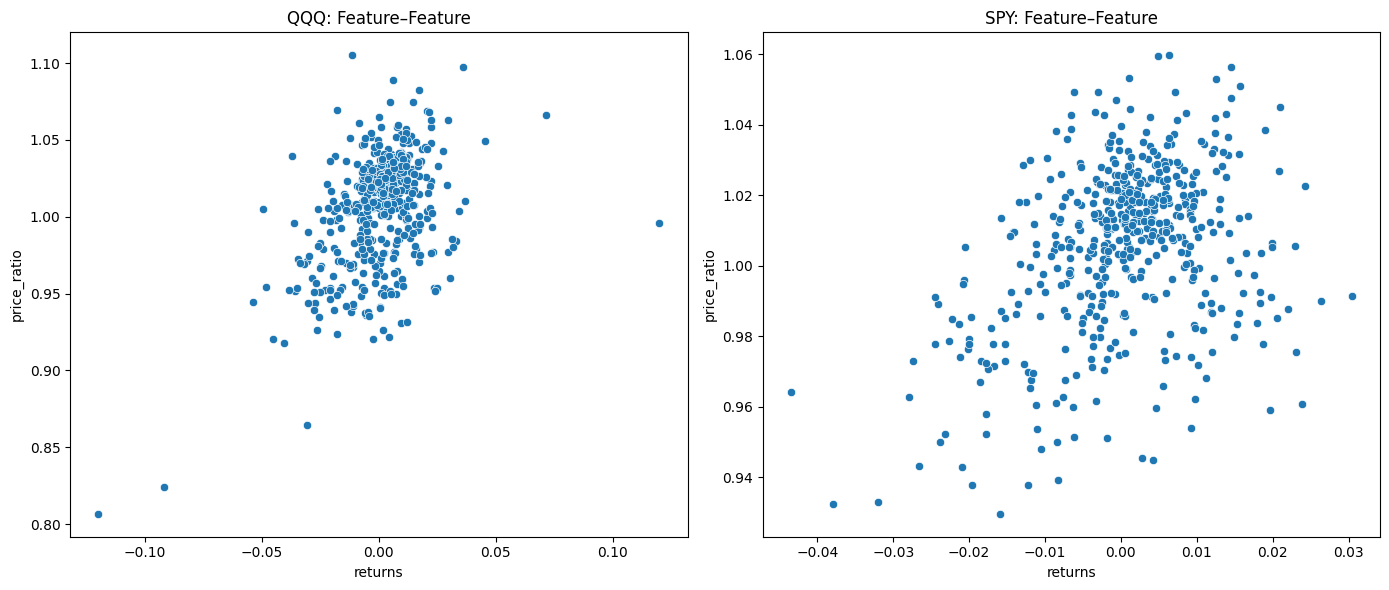

In [ ]:
# Feature–Feature relationship Scatter Plots (QQQ vs SPY)

import matplotlib.pyplot as plt
import seaborn as sns

# Sample and choose features
features = ['returns', 'price_ratio']
qqq_sample = qqq_clean.sample(500, random_state=1)
spy_sample = spy_clean.sample(500, random_state=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# QQQ plot
sns.scatterplot(data=qqq_sample, x=features[0], y=features[1], ax=axes[0])
axes[0].set_title("QQQ: Feature–Feature")
axes[0].set_xlabel(features[0])
axes[0].set_ylabel(features[1])

# SPY plot
sns.scatterplot(data=spy_sample, x=features[0], y=features[1], ax=axes[1])
axes[1].set_title("SPY: Feature–Feature")
axes[1].set_xlabel(features[0])
axes[1].set_ylabel(features[1])

plt.tight_layout()
plt.show()


   Feature–Feature (Scatter Plots):

QQQ: returns and price_ratio show mild positive correlation with some spread.

SPY: Similar trend, but slightly tighter cluster, suggesting a more stable price-return structure.

Both ETFs show a non-linear pattern, but QQQ is slightly more volatile.

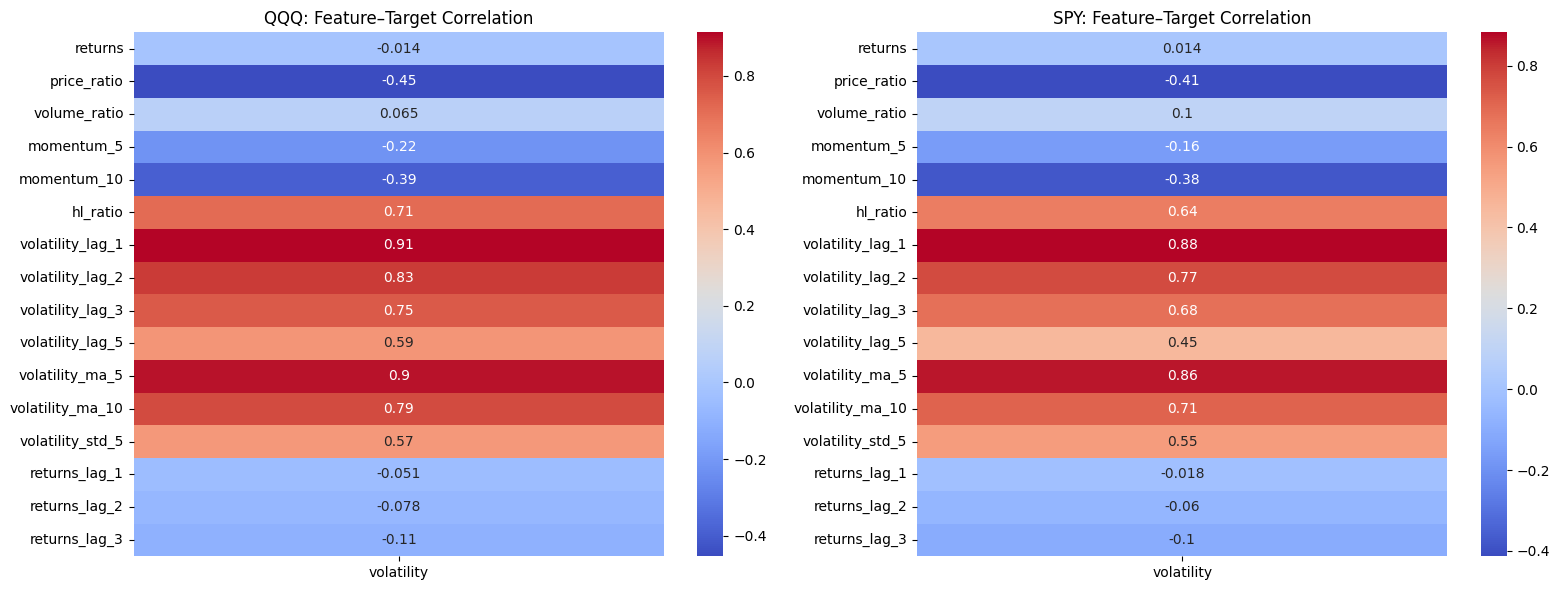

In [ ]:
# Feature–Target Correlation Heatmaps (QQQ vs SPY)

# Select features + target
features = feature_columns + [target_column]
qqq_corr = qqq_clean[features].corr()
spy_corr = spy_clean[features].corr()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# QQQ heatmap
sns.heatmap(qqq_corr[[target_column]].drop(target_column), annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title("QQQ: Feature–Target Correlation")

# SPY heatmap
sns.heatmap(spy_corr[[target_column]].drop(target_column), annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title("SPY: Feature–Target Correlation")

plt.tight_layout()
plt.show()


Feature–Target (Correlation Heatmaps):

In both QQQ and SPY, volatility_lag_1, volatility_lag_2, and volatility_ma_5 show strong positive correlation with current volatility (good predictors).

hl_ratio is also positively correlated, stronger in QQQ.

Returns and price_ratio have weak or negative correlation with volatility (not good predictors on their own).

Overall, QQQ features have slightly stronger correlations with target than SPY.

In [ ]:
# ================================
# BUILD LSTM MODELS for Each Stock
# ================================
def build_lstm_model(input_shape):
    """Build LSTM model architecture"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

LSTM (Long Short-Term Memory) is the best model for this task because it is designed to capture temporal dependencies in time-series data, making it ideal for predicting future volatility based on past patterns. Unlike traditional models, LSTMs can remember long-term trends and handle lagged sequences effectively, which is critical for financial volatility forecasting. This model falls under supervised learning because the model learns from labeled input-output pairs (historical features and known volatility values). It is also a regression problem, as the target variable — volatility — is continuous rather than categorical.

# 3. Model training and testing

    The data has already been prepared during the Pre-processing phase and is ready for modelling.

In [ ]:
# ================================
# TRAIN THE MODEL
# ================================

def train_model(X_train, y_train, stock_name):
    """Train model for a single stock"""
    model = build_lstm_model((10, len(feature_columns)))
    print(f"\nTraining {stock_name} model...")
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=40,
        validation_split=0.2,
        verbose=1,
        shuffle=False
    )
    return model, history

qqq_model, qqq_history = train_model(qqq_X_train_scaled, qqq_y_train_scaled, "QQQ")
spy_model, spy_history = train_model(spy_X_train_scaled, spy_y_train_scaled, "SPY")

print("Model training completed for both stocks")



Training QQQ model...
Epoch 1/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0207 - mae: 0.0930 - val_loss: 0.0024 - val_mae: 0.0410
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0131 - mae: 0.0704 - val_loss: 0.0012 - val_mae: 0.0290
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0097 - mae: 0.0600 - val_loss: 0.0034 - val_mae: 0.0498
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0102 - mae: 0.0631 - val_loss: 0.0012 - val_mae: 0.0285
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0073 - mae: 0.0529 - val_loss: 0.0013 - val_mae: 0.0297
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0072 - mae: 0.0515 - val_loss: 0.0015 - val_mae: 0.0321
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0060 - mae: 0.0497 - val_loss: 0.0012 - val_mae: 0.0285
Epoch 8/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0065 - mae: 0.0488 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 9/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
# ================================
# PREDICTIONS AND EVALUATION
# ================================

def evaluate_model(model, X_train, X_test, y_train, y_test, target_scaler, stock_name):
    """Evaluate model for a single stock"""
    y_train_pred_scaled = model.predict(X_train)
    y_test_pred_scaled = model.predict(X_test)
    y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled).flatten()
    y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled).flatten()
    return y_train_pred, y_test_pred

def calculate_metrics(y_true, y_pred, dataset_name):
    """Calculate and print evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{dataset_name} Metrics:")
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R²: {r2:.4f}")
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

#  Display Evaluation metrics in a table
def display_metrics_table(qqq_metrics, spy_metrics):
    """Display metrics in a formatted table"""
    metrics_df = pd.DataFrame({
        'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
        'QQQ Train': [qqq_train_metrics['mse'], qqq_train_metrics['rmse'], qqq_train_metrics['mae'], qqq_train_metrics['r2']],
        'QQQ Test': [qqq_test_metrics['mse'], qqq_test_metrics['rmse'], qqq_test_metrics['mae'], qqq_test_metrics['r2']],
        'SPY Train': [spy_train_metrics['mse'], spy_train_metrics['rmse'], spy_train_metrics['mae'], spy_train_metrics['r2']],
        'SPY Test': [spy_test_metrics['mse'], spy_test_metrics['rmse'], spy_test_metrics['mae'], spy_test_metrics['r2']]
    })
    print("\n" + "="*50)
    print("MODEL METRICS SUMMARY")
    print("="*50)
    print(metrics_df.to_string(index=False))
    return metrics_df

# New function for real-time predictions
def simulate_real_time_predictions(model, X_test, y_test, target_scaler, stock_name, num_points=10):
    """Simulate real-time predictions"""
    print(f"\nSimulating real-time predictions for {stock_name} (first {num_points} points)...")
    y_pred = []
    for i in range(min(num_points, len(X_test))):
        X_sample = X_test[i:i+1]
        pred_scaled = model.predict(X_sample, verbose=0)
        pred = target_scaler.inverse_transform(pred_scaled).flatten()[0]
        actual = target_scaler.inverse_transform(y_test[i:i+1].reshape(-1, 1)).flatten()[0]
        y_pred.append(pred)
        print(f"Time step {i+1}: Actual Volatility = {actual:.6f}, Predicted Volatility = {pred:.6f}")
        time.sleep(1)  # Simulate delay for real-time effect
    return np.array(y_pred)

# Evaluate both models
qqq_y_train_pred, qqq_y_test_pred = evaluate_model(
    qqq_model, qqq_X_train_scaled, qqq_X_test_scaled,
    qqq_y_train, qqq_y_test, qqq_target_scaler, "QQQ")

spy_y_train_pred, spy_y_test_pred = evaluate_model(
    spy_model, spy_X_train_scaled, spy_X_test_scaled,
    spy_y_train, spy_y_test, spy_target_scaler, "SPY")

print("=" * 50)
print("QQQ MODEL EVALUATION")
print("=" * 50)
qqq_train_metrics = calculate_metrics(qqq_y_train, qqq_y_train_pred, "QQQ Training")
qqq_test_metrics = calculate_metrics(qqq_y_test, qqq_y_test_pred, "QQQ Test")

print("=" * 50)
print("SPY MODEL EVALUATION")
print("=" * 50)
spy_train_metrics = calculate_metrics(spy_y_train, spy_y_train_pred, "SPY Training")
spy_test_metrics = calculate_metrics(spy_y_test, spy_y_test_pred, "SPY Test")

# Display metrics table
metrics_table = display_metrics_table(qqq_train_metrics, spy_train_metrics)

# Simulate real-time predictions
qqq_real_time_preds = simulate_real_time_predictions(qqq_model, qqq_X_test_scaled, qqq_y_test_scaled, qqq_target_scaler, "QQQ")
spy_real_time_preds = simulate_real_time_predictions(spy_model, spy_X_test_scaled, spy_y_test_scaled, spy_target_scaler, "SPY")

# Show R2 Evaluation results
print("\n" + "="*50)
print("SEPARATE LSTM MODELS COMPLETED")
print("="*50)
print(f"QQQ Final Test RMSE: {qqq_test_metrics['rmse']:.6f}, R²: {qqq_test_metrics['r2']:.4f}")
print(f"SPY Final Test RMSE: {spy_test_metrics['rmse']:.6f}, R²: {spy_test_metrics['r2']:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
QQQ MODEL EVALUATION

QQQ Training Metrics:
MSE: 0.000088
RMSE: 0.009407
MAE: 0.006976
R²: 0.8017

QQQ Test Metrics:
MSE: 0.000093
RMSE: 0.009667
MAE: 0.006943
R²: 0.7727
SPY MODEL EVALUATION

SPY Training Metrics:
MSE: 0.000037
RMSE: 0.006118
MAE: 0.004516
R²: 0.7089

SPY Test Metrics:
MSE: 0.000080
RMSE: 0.008940
MAE: 0.005639
R²: 0.7876

MODEL METRICS SUMMARY
Metric  QQQ Train  QQQ Test  SPY Train  SPY Test
   MSE   0.000088  0.000093   0.000037  0.000080
  RMSE   0.009407  0.009667   0.006118  0.008940
   MAE   0.006976  0.006943   0.004516  0.005639
    R²   0.801724  0.772691   0.708914  0.787602

Simulating real-time predictions for QQQ (first 10 points)...
Time step 1: Actual Volatility = 0.015373, Predicted Volatility = 0.022454
Time step 2: Actual Volatility = 0.014904, Predicted Volatility = 0.024277
Time step 3: Actual 

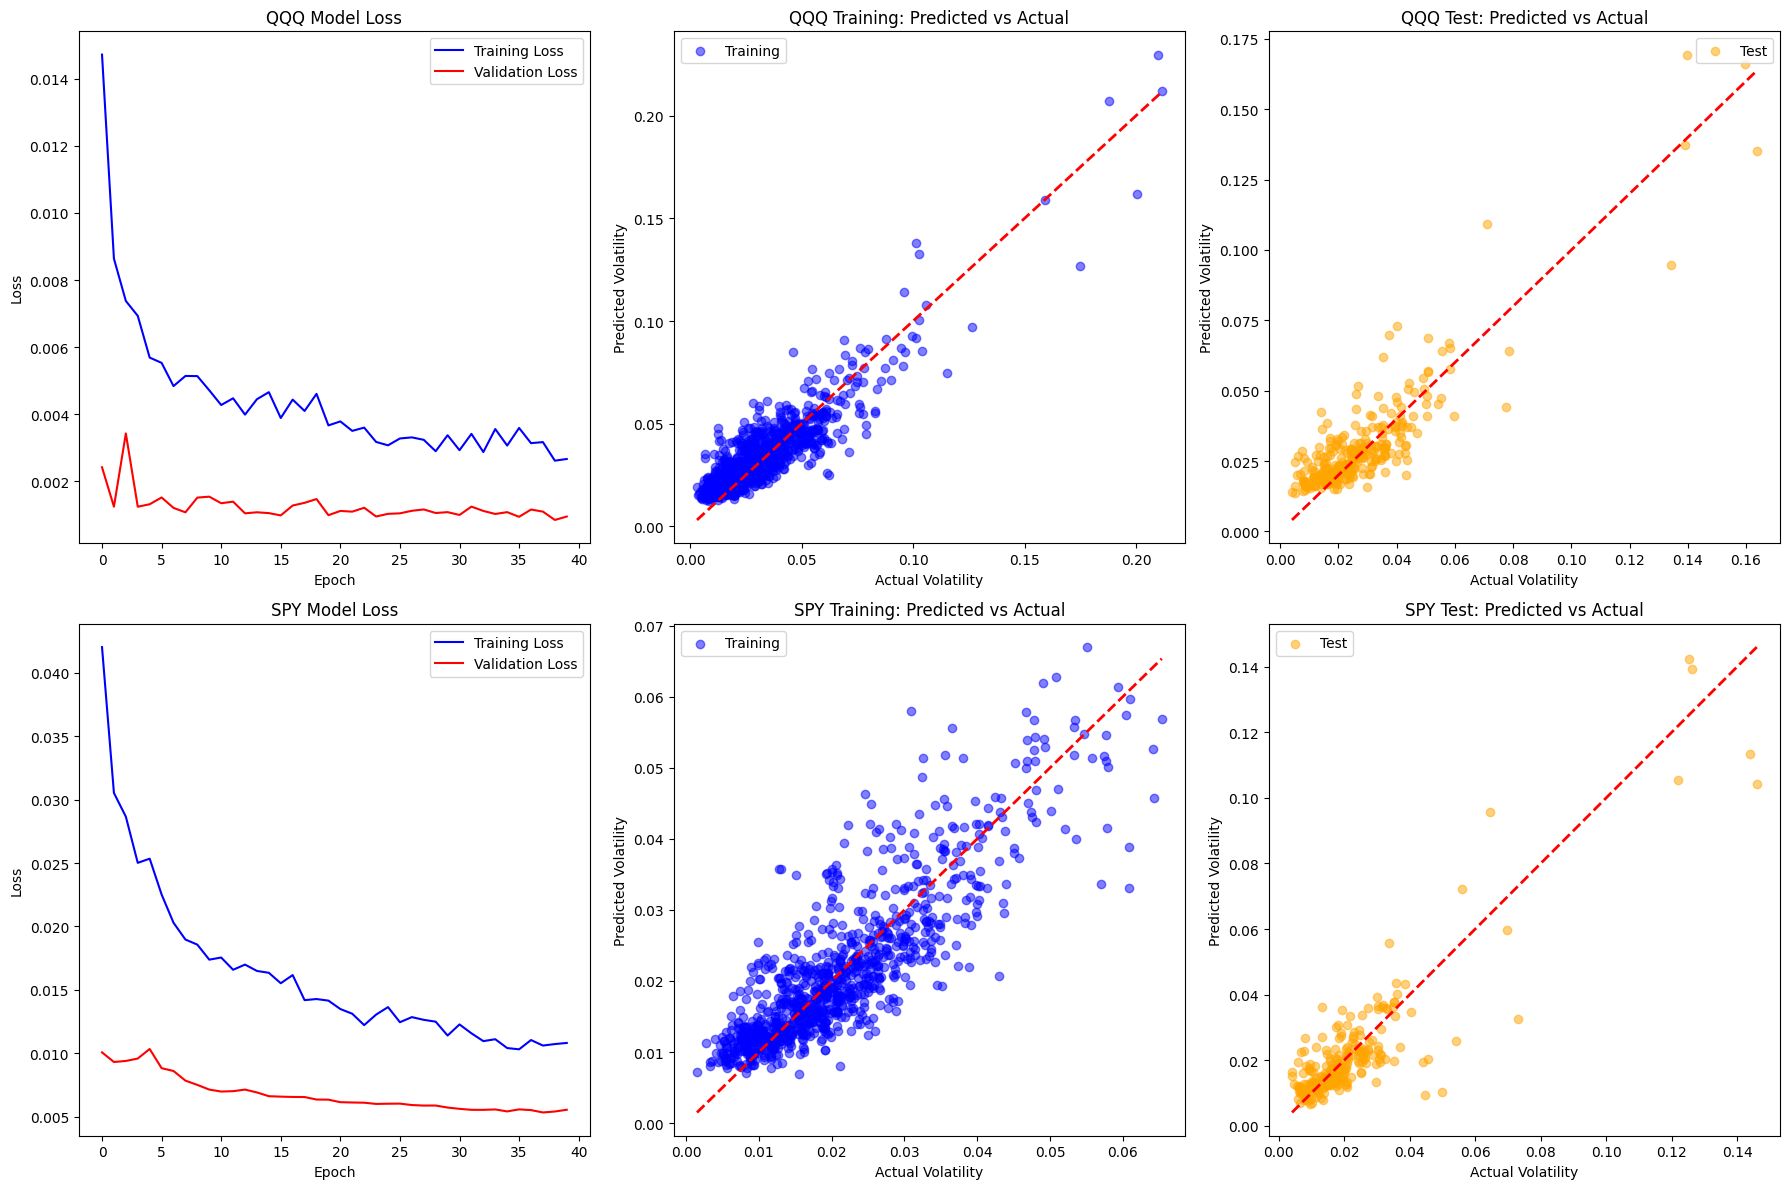

In [ ]:

# ================================
# CHECK FOR OVERTTING USING VISUALIZATIONS
# ================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# QQQ plots
axes[0, 0].plot(qqq_history.history['loss'], label='Training Loss', color='blue')
axes[0, 0].plot(qqq_history.history['val_loss'], label='Validation Loss', color='red')
axes[0, 0].set_title('QQQ Model Loss', fontsize=12)
axes[0, 0].set_xlabel('Epoch', fontsize=10)
axes[0, 0].set_ylabel('Loss', fontsize=10)
axes[0, 0].legend()

axes[0, 1].scatter(qqq_y_train, qqq_y_train_pred, alpha=0.5, label='Training', color='blue')
axes[0, 1].plot([qqq_y_train.min(), qqq_y_train.max()], [qqq_y_train.min(), qqq_y_train.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Volatility', fontsize=10)
axes[0, 1].set_ylabel('Predicted Volatility', fontsize=10)
axes[0, 1].set_title('QQQ Training: Predicted vs Actual', fontsize=12)
axes[0, 1].legend()

axes[0, 2].scatter(qqq_y_test, qqq_y_test_pred, alpha=0.5, label='Test', color='orange')
axes[0, 2].plot([qqq_y_test.min(), qqq_y_test.max()], [qqq_y_test.min(), qqq_y_test.max()], 'r--', lw=2)
axes[0, 2].set_xlabel('Actual Volatility', fontsize=10)
axes[0, 2].set_ylabel('Predicted Volatility', fontsize=10)
axes[0, 2].set_title('QQQ Test: Predicted vs Actual', fontsize=12)
axes[0, 2].legend()

# SPY plots
axes[1, 0].plot(spy_history.history['loss'], label='Training Loss', color='blue')
axes[1, 0].plot(spy_history.history['val_loss'], label='Validation Loss', color='red')
axes[1, 0].set_title('SPY Model Loss', fontsize=12)
axes[1, 0].set_xlabel('Epoch', fontsize=10)
axes[1, 0].set_ylabel('Loss', fontsize=10)
axes[1, 0].legend()

axes[1, 1].scatter(spy_y_train, spy_y_train_pred, alpha=0.5, label='Training', color='blue')
axes[1, 1].plot([spy_y_train.min(), spy_y_train.max()], [spy_y_train.min(), spy_y_train.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Volatility', fontsize=10)
axes[1, 1].set_ylabel('Predicted Volatility', fontsize=10)
axes[1, 1].set_title('SPY Training: Predicted vs Actual', fontsize=12)
axes[1, 1].legend()

axes[1, 2].scatter(spy_y_test, spy_y_test_pred, alpha=0.5, label='Test', color='orange')
axes[1, 2].plot([spy_y_test.min(), spy_y_test.max()], [spy_y_test.min(), spy_y_test.max()], 'r--', lw=2)
axes[1, 2].set_xlabel('Actual Volatility', fontsize=10)
axes[1, 2].set_ylabel('Predicted Volatility', fontsize=10)
axes[1, 2].set_title('SPY Test: Predicted vs Actual', fontsize=12)
axes[1, 2].legend()

plt.tight_layout()
plt.show()



    Model showed signs of overfitting i added dropout and reduced epoch size, the model Generalizes well now. As shown by Plots.

In [ ]:
# Show Final Evaluation results
print("\n" + "="*50)
print("SEPARATE LSTM MODELS COMPLETED")
print("="*50)
print(f"QQQ Final Test RMSE: {qqq_test_metrics['rmse']:.6f}, R²: {qqq_test_metrics['r2']:.4f}")
print(f"SPY Final Test RMSE: {spy_test_metrics['rmse']:.6f}, R²: {spy_test_metrics['r2']:.4f}")


SEPARATE LSTM MODELS COMPLETED
QQQ Final Test RMSE: 0.009667, R²: 0.7727
SPY Final Test RMSE: 0.008940, R²: 0.7876


# Export the Models, Metrics and Scalers

In [ ]:
import joblib
import pickle
import json

# Save models in .keras format
qqq_model.save('qqq_model.keras')
spy_model.save('spy_model.keras')

# Save scalers
joblib.dump(qqq_feature_scaler, 'qqq_feature_scaler.pkl')
joblib.dump(qqq_target_scaler, 'qqq_target_scaler.pkl')
joblib.dump(spy_feature_scaler, 'spy_feature_scaler.pkl')
joblib.dump(spy_target_scaler, 'spy_target_scaler.pkl')

# Save metrics to JSON
all_metrics = {
    'qqq_train': qqq_train_metrics,
    'qqq_test': qqq_test_metrics,
    'spy_train': spy_train_metrics,
    'spy_test': spy_test_metrics
}

with open('model_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=4)


# Other Visualizations

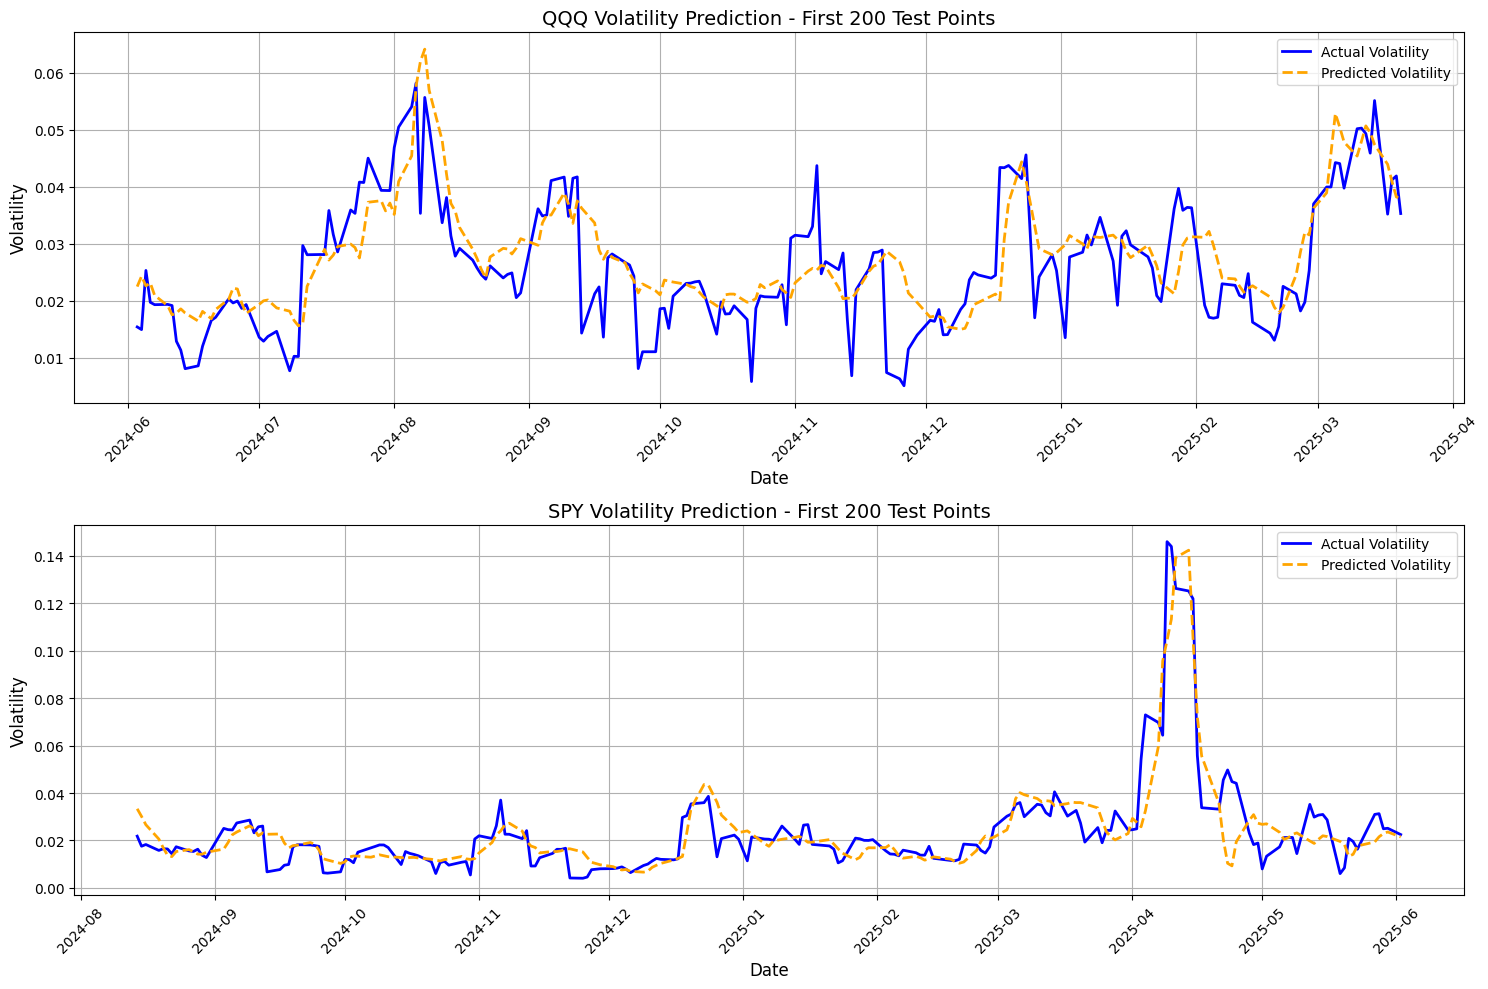

In [ ]:
# Enhanced time series comparison with improved visuals
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# QQQ time series
qqq_test_indices = qqq_clean.index[-len(qqq_y_test):][:200]  # Align with test data dates
axes[0].plot(qqq_test_indices, qqq_y_test[:200], label='Actual Volatility', linewidth=2, color='blue')
axes[0].plot(qqq_test_indices, qqq_y_test_pred[:200], label='Predicted Volatility', linewidth=2, color='orange', linestyle='--')
axes[0].set_title('QQQ Volatility Prediction - First 200 Test Points', fontsize=14)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Volatility', fontsize=12)
axes[0].legend()
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# SPY time series
spy_test_indices = spy_clean.index[-len(spy_y_test):][:200]  # Align with test data dates
axes[1].plot(spy_test_indices, spy_y_test[:200], label='Actual Volatility', linewidth=2, color='blue')
axes[1].plot(spy_test_indices, spy_y_test_pred[:200], label='Predicted Volatility', linewidth=2, color='orange', linestyle='--')
axes[1].set_title('SPY Volatility Prediction - First 200 Test Points', fontsize=14)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Volatility', fontsize=12)
axes[1].legend()
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()